# Tutorial
## Getting started
### Import library and packages

In [1]:
import os
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import ResoFit
from ResoFit.calibration import Calibration
from ResoFit.fitresonance import FitResonance
import numpy as np

### Global paramters
  - min energy of **7 eV** (has to be greater than **1 x 10<sup>-5</sup> eV**)
  - max energy of **150 eV** (has to be less than **3000 eV**)
  - energy steps to interpolate database: **0.1 eV**

In [2]:
energy_min = 7
energy_max = 150
energy_step = 0.01

### File locations for calibriation and resonance fitting

  - */data (directory to locate the file)
  - data_file (YOUR_DATA_FILE.txt or .csv)
  - spectra_file (YOUR_SPECTRA_FILE.txt or .csv)

In [3]:
folder = 'data'
data_file = 'all_thick_div.txt'
spectra_file = 'Image002_Spectra.txt'

### Sample info

  - **Gd** foil
  - **thickness** neutron path within the sample in (**mm**)
  - **density** sample density in (**g/cm<sup>3</sup>**), if omitted, pure solid density will be used in fitting
  - **repeat** : reptition number if the data is summed of multiple runs (**default: 1**)

In [4]:
layer_1 = 'Gd'
thickness_1 = 0.15  # mm
density_1 = np.NaN # g/cm^3 (if omitted, pure solid density will be used in fitting step)
repeat = 1

## Calibration
### Estimated intrumental parameters

  - input estimated **source to detector distance** (**m**)
  - input estimated possible **time offset** in spectra file (**us**)

In [5]:
source_to_detector_m = 16.
offset_us = 0

### Class initialization

  - Pass all the parameters definded above into the Calibration()

In [6]:
calibration = Calibration(data_file=data_file,
                          spectra_file=spectra_file,
                          layer_1=layer_1,
                          thickness_1=thickness_1,
                          density_1=np.NaN,
                          energy_min=energy_min,
                          energy_max=energy_max,
                          energy_step=energy_step,
                          repeat=repeat,
                          folder=folder)

### Equations for (time-wavelength-energy) conversion



$$E = \frac {81.787 }{ \lambda^2 }$$

$E$ : energy in (meV),

$\lambda$ : wavelength in (Å).

$$\lambda  = 0.3956\frac{t_{record} + t_{offset}}{L}$$

$t_{record}$ : recorded time in (µs),

$t_{offset}$ : recorded time offset in (µs),

$L$ : source to detector distance in (cm).

### Calibrate instrumental parameters

  - using **source_to_detector_m** or **offset_us** or **both** to minimize the difference between the measured resonance signals and the simulated resonance signals from *ImagingReso* within the range specified in **global parameters**
  - **vary** can be one of **['source_to_detector', 'offset', 'all']** (default is **'all'**)
  - fitting parameters are displayed

In [7]:
calibration.calibrate(source_to_detector_m=source_to_detector_m,
                      offset_us=offset_us,
                      vary='all')

Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us                2.695     -inf      inf  0.04659     True     None     None
source_to_detector_m     16.44     -inf      inf 0.004409     True     None     None


### Retrieve calibrated parameters

In [8]:
calibration.calibrated_offset_us

2.6951060207167301

In [9]:
calibration.calibrated_source_to_detector_m

16.442106977781563

### Plot calibration result

  - using the best fitted **source_to_detector_m** and **offset_us** to show the calibrated resonance signals from measured data and the expected resonance positions from *ImagingReso*
  - measured data before and after is ploted with raw data points instead of interpolated data points. However, the interpolated data was used during the calibration step above.

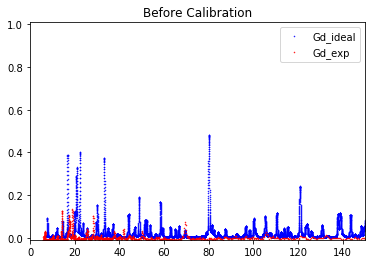

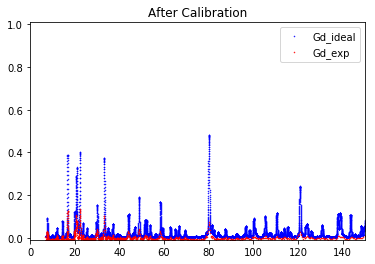

In [10]:
calibration.plot_before()
calibration.plot_after()

## Fit resonances
### Class initialization

  - Pass all the parameters definded and calibrated into the FitResonance()

In [11]:
fit = FitResonance(spectra_file=spectra_file,
                   data_file=data_file,
                   layer=layer_1,
                   repeat=repeat,
                   energy_min=energy_min,
                   energy_max=energy_max,
                   energy_step=energy_step,
                   calibrated_offset_us=calibration.calibrated_offset_us,
                   calibrated_source_to_detector_m=calibration.calibrated_source_to_detector_m)

### Fitting equations
#### Beer-Lambert Law:

$$T\left( E \right) =\frac { I\left( E \right)  }{ { I }_{ 0 }\left( E \right)  } =exp\left[ -\sum\nolimits_i { { N }_{ i }{ d }_{ i } } \sum\nolimits_j { { \sigma  }_{ ij }\left( E \right) { A }_{ ij } }  \right]$$

${ N }_{ i }$ : number of atoms per unit volume of element $i$,

${ d }_{ i }$ : effective thickness along the neutron path of element $i$,

${ \sigma  }_{ ij }\left( E \right)$  : energy-dependent neutron total cross-section for the isotope $j$ of element $i$,

${ A }_{ ij }$ : abundance for the isotope $j$ of element $i$.

$${N_i} = {N_A}{C_i} = \frac { {N_A}{\rho_i}} {\sum\nolimits_j {m_{ij}{A_{ij}}}}$$

${N_A}$ : Avogadro’s number,

${C_i}$ : molar concentration of element $i$,

${\rho_i}$ : density of the element $i$,

$m_{ij}$ : atomic mass values for the isotope $j$ of element $i$.


#### How to fit the resonance signals

  - using **thickness** (mm) or **density** (g/cm<sup>3</sup>) to minimize the difference between the measured resonance signals and the simulated resonance signals from *ImagingReso* within the range specified in **global parameters**
  - **vary** can be one of **['thickness', 'density']** (default is **'density'**)
  - fitting parameters are displayed

In [12]:
fit.fit(thickness=thickness_1, density=density_1, vary='density')

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
density       1.567        0      inf 0.004456     True     None     None
thickness      0.15        0      inf        0    False     None     None


### Output fitted result in molar concentration

  - unit: mol/cm<sup>3</sup>

In [13]:
fit.molar_conc(layer_1)

Molar conc. of element Gd in layer Gd is: 0.009962583893737246 (mol/cm3)


0.0099625838937372462

### Plot fitting result

  - using the best fitted **density** to show the measured resonance signals and the fitted resonance signals from *ImagingReso*
  - measured data before and after is ploted with raw data points instead of interpolated data points. However, the interpolated data was used during the fitting step above.

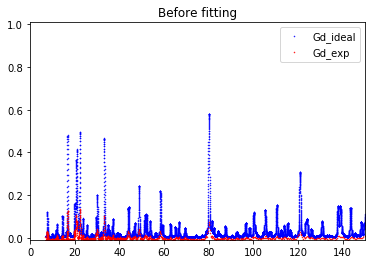

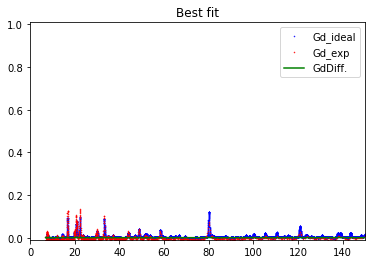

In [14]:
fit.plot_before()
fit.plot_after()